# Melanoma Detection

Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from glob import glob

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
# Update the paths of the train and test dataset
data_train = pathlib.Path("/content/gdrive/MyDrive/CNN/kaggle/Train")
data_test = pathlib.Path('/content/gdrive/MyDrive/CNN/kaggle/Test')

In [4]:
train_count = len(list(data_train.glob('*/*.jpg')))
print(train_count)
test_count = len(list(data_test.glob('*/*.jpg')))
print(test_count)

2239
118


## keras preprocessing
### Create a dataset and load the images
- Split 80% of the images for training, and 20% for validation.


In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# train dataset
# Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# validation dataset
# use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# make sure your resize your images to the size img_height*img_width, while writting the dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Creating one batch for test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_test,
    seed=123,
    batch_size=118,
    image_size=(img_height,img_width)
)

Found 118 files belonging to 9 classes.


In [9]:
# List of all the classes of skin cancer
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


In [10]:
validation_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [11]:
# The tf.data.Dataset API supports writing descriptive and efficient input pipelines
# Create a source dataset from your input data
# Apply dataset transformations to preprocess the data
# Iterate over the dataset and process the elements
dataset = tf.data.Dataset.range(10)
print(list(dataset.as_numpy_iterator()))
dataset1 = dataset.take(3)
print(list(dataset1.as_numpy_iterator()))
dataset2 = dataset.take(5)
print(list(dataset2.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2]
[0, 1, 2, 3, 4]


In [ ]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Visualize the Data
- create a code to visualize one instance of all the nine   classes present in the dataset

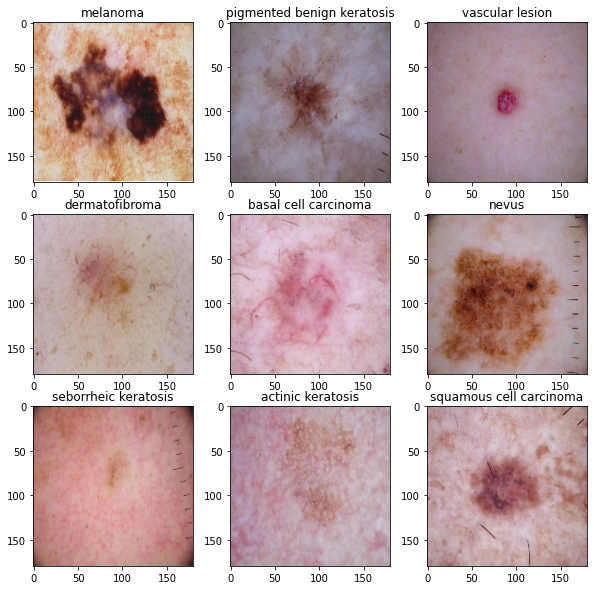

In [13]:
# Use training or Validation data to Visualize
plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,10))
for images, labels in validation_ds.take(50):
  if not visited_all:
    for i in range(9):
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(3,3,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"));
        plt.title(class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
  else:
    break

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

#### tf.data builds a performance model of the input pipeline and runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as AUTOTUNE

In [14]:
dataset = tf.data.Dataset.range(5)
print(list(dataset.as_numpy_iterator()))
dataset = dataset.map(lambda x: x**2)
print(list(dataset.as_numpy_iterator()))
dataset = dataset.cache()
# The first time reading through the data will generate the data using
# `range` and `map`.
print(list(dataset.as_numpy_iterator()))

# Subsequent iterations read from the cache.
print(list(dataset.as_numpy_iterator()))

[0, 1, 2, 3, 4]
[0, 1, 4, 9, 16]
[0, 1, 4, 9, 16]
[0, 1, 4, 9, 16]


In [15]:
dataset = tf.data.Dataset.range(3)
print(list(dataset.as_numpy_iterator()))
dataset = dataset.prefetch(2)
print(list(dataset.as_numpy_iterator()))

[0, 1, 2]
[0, 1, 2]


In [16]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building

- Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. It is good to standardize values to be in the [0, 1]

In [17]:
# Rescaling Layer: A preprocessing layer which rescales input values to a new range.
# Rescale images to normalize pixel values between (0,1).
num_classes = 9

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2D layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
                    ])



# Compile the Model
Choose an appropirate optimiser and loss function for model training

In [18]:
# choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

In [19]:
#  Use GPU runtime
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


## Train the Model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 144s 238ms/step - loss: 2.8099 - accuracy: 0.1936 - val_loss: 2.0376 - val_accuracy: 0.2260
Epoch 2/20
56/56 [==============================] - 6s 109ms/step - loss: 2.0152 - accuracy: 0.2266 - val_loss: 2.1528 - val_accuracy: 0.2662
Epoch 3/20
56/56 [==============================] - 6s 109ms/step - loss: 1.9739 - accuracy: 0.2740 - val_loss: 1.9176 - val_accuracy: 0.3266
Epoch 4/20
56/56 [==============================] - 6s 109ms/step - loss: 1.8815 - accuracy: 0.2974 - val_loss: 1.8666 - val_accuracy: 0.3043
Epoch 5/20
56/56 [==============================] - 6s 110ms/step - loss: 1.8696 - accuracy: 0.3220 - val_loss: 1.9186 - val_accuracy: 0.2819
Epoch 6/20
56/56 [==============================] - 6s 109ms/step - loss: 1.7699 - accuracy: 0.3493 - val_loss: 1.9141 - val_accuracy: 0.2550
Epoch 7/20
56/56 [==============================] - 6s 110ms/step - loss: 1.6430 - accuracy: 0.4118 - val_loss: 1.6975 - val_accuracy: 0.3960
Epoc

## Visualizing training results

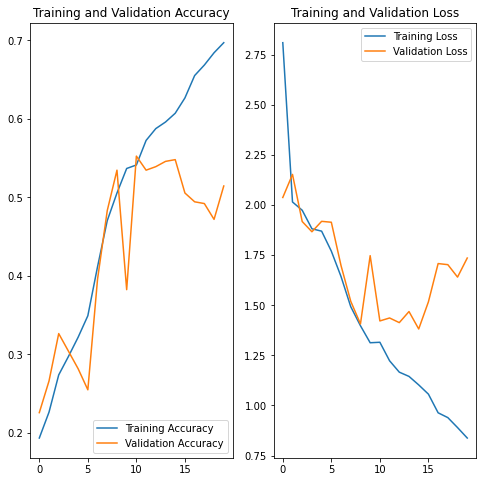

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  # print(model.predict_classes(images))
  # print(labels.numpy())
  y_true=list(labels.numpy())
  y_pred=np.argmax(model.predict(images), axis=-1)
  # break
print(classification_report(y_true,y_pred,target_names=class_names))
print("*"*20)
print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))

                            precision    recall  f1-score   support

         actinic keratosis       0.33      0.06      0.11        16
      basal cell carcinoma       0.30      0.38      0.33        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.20      0.25      0.22        16
                     nevus       0.29      0.75      0.41        16
pigmented benign keratosis       0.50      0.69      0.58        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.33      0.06      0.11        16
           vascular lesion       0.33      0.67      0.44         3

                  accuracy                           0.31       118
                 macro avg       0.25      0.32      0.24       118
              weighted avg       0.27      0.31      0.25       118

********************
Accuracy on test dataset :  0.3135593220338983


In [23]:
# lets try the same model with more epochs and different opitmizer
num_classes = 9

model_rmsprop = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2D layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_rmsprop.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
history_rmsprop = model_rmsprop.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 8s 116ms/step - loss: 4.6111 - accuracy: 0.2377 - val_loss: 2.1284 - val_accuracy: 0.2371
Epoch 2/30
56/56 [==============================] - 3s 62ms/step - loss: 2.0264 - accuracy: 0.2807 - val_loss: 1.8909 - val_accuracy: 0.4474
Epoch 3/30
56/56 [==============================] - 3s 62ms/step - loss: 1.8971 - accuracy: 0.3426 - val_loss: 2.2078 - val_accuracy: 0.2327
Epoch 4/30
56/56 [==============================] - 3s 62ms/step - loss: 1.8132 - accuracy: 0.3895 - val_loss: 1.6544 - val_accuracy: 0.4407
Epoch 5/30
56/56 [==============================] - 3s 62ms/step - loss: 1.6603 - accuracy: 0.4431 - val_loss: 1.6131 - val_accuracy: 0.4832
Epoch 6/30
56/56 [==============================] - 3s 62ms/step - loss: 1.5498 - accuracy: 0.4743 - val_loss: 1.5734 - val_accuracy: 0.4989
Epoch 7/30
56/56 [==============================] - 3s 62ms/step - loss: 1.5022 - accuracy: 0.4955 - val_loss: 1.7259 - val_accuracy: 0.4072
Epoch 8/30
5

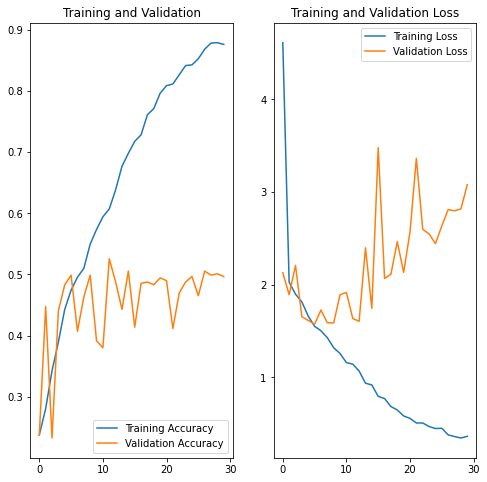

In [24]:
#visualizing results

acc = history_rmsprop.history['accuracy']
val_acc = history_rmsprop.history['val_accuracy']

loss = history_rmsprop.history['loss']
val_loss = history_rmsprop.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  # print(model.predict_classes(images))
  # print(labels.numpy())
  y_true=list(labels.numpy())
  y_pred=np.argmax(model_rmsprop.predict(images), axis=-1)
  # break
print(classification_report(y_true,y_pred,target_names=class_names))
print("*"*20)
print("RMS prop Accuracy on test dataset : ",accuracy_score(y_true,y_pred))

                            precision    recall  f1-score   support

         actinic keratosis       1.00      0.06      0.12        16
      basal cell carcinoma       0.40      0.25      0.31        16
            dermatofibroma       0.25      0.06      0.10        16
                  melanoma       0.35      0.38      0.36        16
                     nevus       0.19      0.44      0.27        16
pigmented benign keratosis       0.29      0.62      0.40        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.23      0.19      0.21        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.29       118
                 macro avg       0.38      0.30      0.27       118
              weighted avg       0.39      0.29      0.26       118

********************
RMS prop Accuracy on test dataset :  0.288135593220339


#### Here we trained the same model with different optimizers (adams , rmsprop) and epochs(20 ,30). As we can see , till 6-7 epochs training and validation accuracy both increase . But after that training accuracy keeps on increasing to 80% whereas validation accuracy keeps fluctuating at 50% . Which means, model has begun to overfit.

In [26]:
# After analysed, the model fit history for presence of overfit, 
# choose an appropriate data augumentation strategy. 
# RandomFlip: A preprocessing layer which randomly flips images during training.

data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

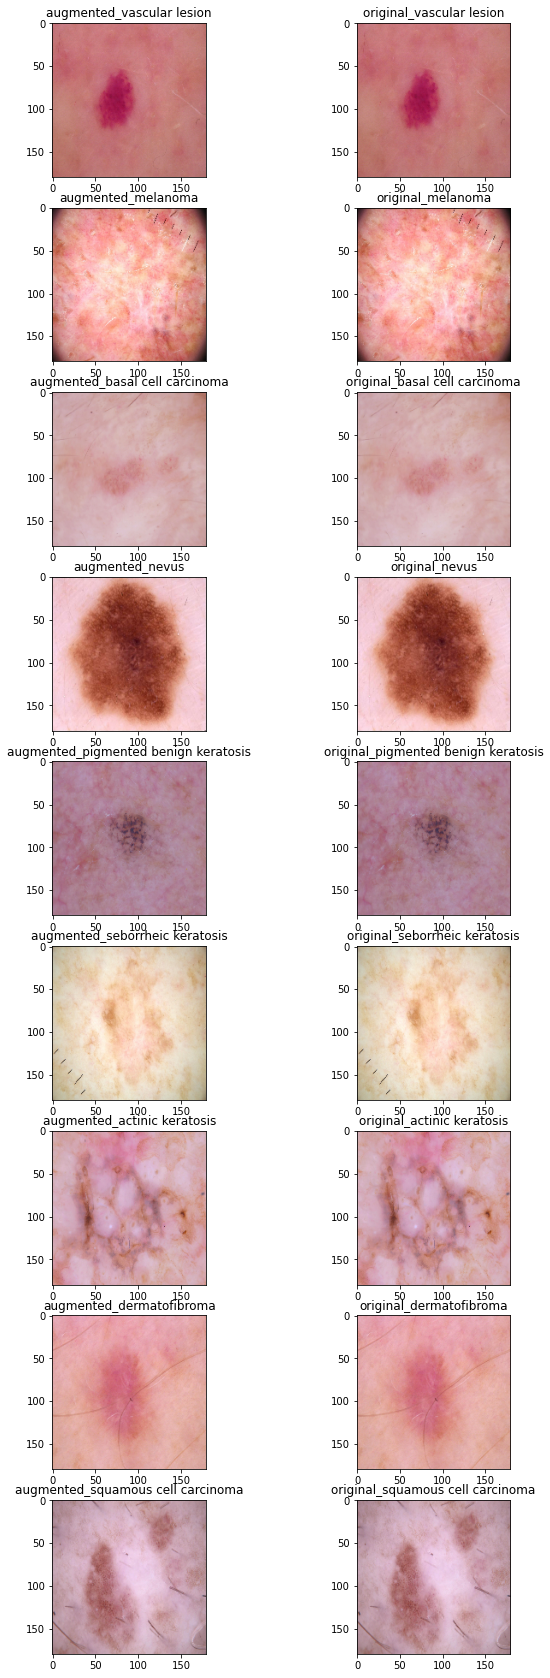

In [27]:
# visualize how augmentation strategy works for one instance of training image.

plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,30))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(9,2,plot_idx+1)
        x=data_aug(images)
        plt.imshow(x[i].numpy().astype("uint8"));
        # plt.imshow(images[i].numpy().astype("uint8"));
        plt.title("augmented_"+class_names[labels[i]])
        plot_idx+=1
        plt.subplot(9,2,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("original_"+class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
        
  else:
    break

## Create the model, compile and train the model

In [28]:
# Use Dropout layer if there is an evidence of overfitting
# choose an appropirate optimiser and loss function

model = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])


### Compiling the model

In [29]:
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        36928     
                                                      

### Training the model

In [30]:
# train model for 20 epochs
# history = training code

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 69ms/step - loss: 3.2265 - accuracy: 0.1719 - val_loss: 2.1569 - val_accuracy: 0.2148
Epoch 2/20
56/56 [==============================] - 3s 62ms/step - loss: 2.0060 - accuracy: 0.2132 - val_loss: 1.9836 - val_accuracy: 0.2506
Epoch 3/20
56/56 [==============================] - 3s 62ms/step - loss: 1.7600 - accuracy: 0.3661 - val_loss: 1.7348 - val_accuracy: 0.3691
Epoch 4/20
56/56 [==============================] - 4s 66ms/step - loss: 1.6204 - accuracy: 0.4135 - val_loss: 1.7661 - val_accuracy: 0.3468
Epoch 5/20
56/56 [==============================] - 3s 63ms/step - loss: 1.5072 - accuracy: 0.4676 - val_loss: 1.5024 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 1.4793 - accuracy: 0.4782 - val_loss: 1.4647 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 3s 62ms/step - loss: 1.4306 - accuracy: 0.4905 - val_loss: 1.5253 - val_accuracy: 0.4541
Epoch 8/20
56

### Visualizing the results

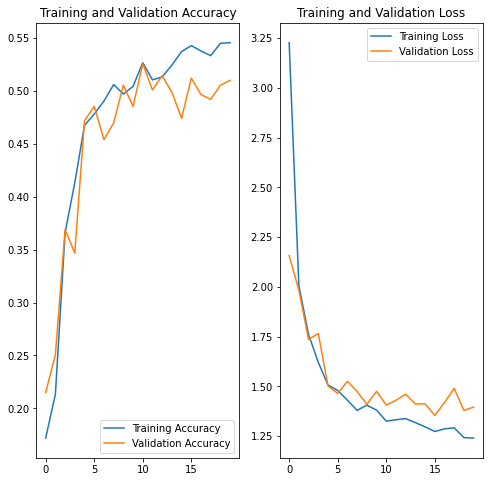

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
# with different optimizer
model_aug_adagrad = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_aug_adagrad.compile(optimizer='adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 25
history_aug_adagrad = model_aug_adagrad.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 5s 65ms/step - loss: 2.0674 - accuracy: 0.1886 - val_loss: 2.0632 - val_accuracy: 0.1588
Epoch 2/25
56/56 [==============================] - 3s 62ms/step - loss: 2.0174 - accuracy: 0.2199 - val_loss: 2.0466 - val_accuracy: 0.1700
Epoch 3/25
56/56 [==============================] - 3s 62ms/step - loss: 2.0119 - accuracy: 0.2344 - val_loss: 2.0177 - val_accuracy: 0.3602
Epoch 4/25
56/56 [==============================] - 3s 62ms/step - loss: 1.9943 - accuracy: 0.2617 - val_loss: 2.0064 - val_accuracy: 0.2483
Epoch 5/25
56/56 [==============================] - 3s 62ms/step - loss: 1.9752 - accuracy: 0.2863 - val_loss: 1.9984 - val_accuracy: 0.2058
Epoch 6/25
56/56 [==============================] - 3s 62ms/step - loss: 1.9516 - accuracy: 0.3047 - val_loss: 1.9740 - val_accuracy: 0.3468
Epoch 7/25
56/56 [==============================] - 3s 62ms/step - loss: 1.9203 - accuracy: 0.3225 - val_loss: 1.9455 - val_accuracy: 0.2662
Epoch 8/25
56

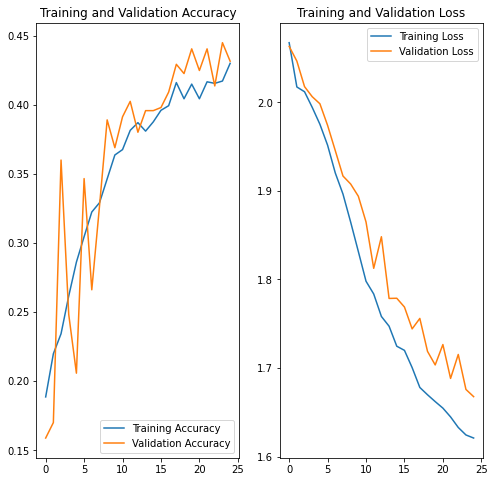

In [33]:
# creating a performance visualisation for adagrad optimiser
acc = history_aug_adagrad.history['accuracy']
val_acc = history_aug_adagrad.history['val_accuracy']

loss = history_aug_adagrad.history['loss']
val_loss = history_aug_adagrad.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
# creating another model with SGD opitmizer
model_aug_sgd = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_aug_sgd.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 25
history_aug_sgd = model_aug_sgd.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 4s 63ms/step - loss: 2.0661 - accuracy: 0.1897 - val_loss: 2.0898 - val_accuracy: 0.2125
Epoch 2/25
56/56 [==============================] - 3s 61ms/step - loss: 2.0277 - accuracy: 0.2249 - val_loss: 2.0720 - val_accuracy: 0.2125
Epoch 3/25
56/56 [==============================] - 3s 61ms/step - loss: 2.0160 - accuracy: 0.2427 - val_loss: 2.0464 - val_accuracy: 0.3468
Epoch 4/25
56/56 [==============================] - 3s 61ms/step - loss: 1.9970 - accuracy: 0.2545 - val_loss: 2.0177 - val_accuracy: 0.3043
Epoch 5/25
56/56 [==============================] - 3s 61ms/step - loss: 1.9855 - accuracy: 0.2734 - val_loss: 2.0080 - val_accuracy: 0.3557
Epoch 6/25
56/56 [==============================] - 3s 61ms/step - loss: 1.9755 - accuracy: 0.2712 - val_loss: 1.9884 - val_accuracy: 0.3982
Epoch 7/25
56/56 [==============================] - 3s 61ms/step - loss: 1.9374 - accuracy: 0.3036 - val_loss: 2.0808 - val_accuracy: 0.2125
Epoch 8/25
56

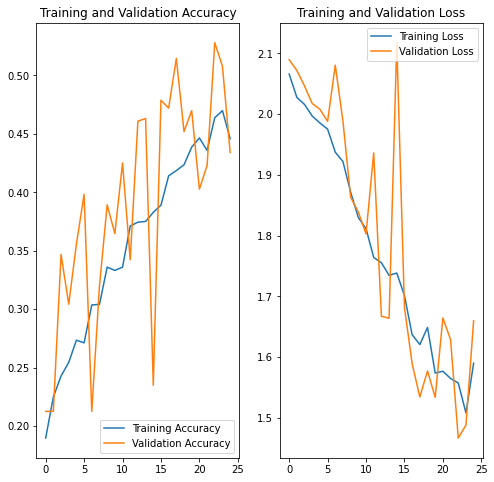

In [35]:
# creating performance visualisation for sgd optimizer
acc = history_aug_sgd.history['accuracy']
val_acc = history_aug_sgd.history['val_accuracy']

loss = history_aug_sgd.history['loss']
val_loss = history_aug_sgd.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
#checking the performance on the test set 
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  # print(model.predict_classes(images))
  # print(labels.numpy())
  y_true=list(labels.numpy())
  y_pred=np.argmax(model.predict(images), axis=-1)
  # break
  print("Adam optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred=np.argmax(model_aug_adagrad.predict(images), axis=-1)
  # break
  print("Adagrad optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred=np.argmax(model_aug_sgd.predict(images), axis=-1)
  # break
  print("SGD optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)

Adam optimizer
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.30      0.75      0.43        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.14      0.12      0.13        16
                     nevus       0.48      0.62      0.54        16
pigmented benign keratosis       0.26      0.56      0.36        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.33      0.12      0.18        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.31       118
                 macro avg       0.24      0.32      0.26       118
              weighted avg       0.22      0.31      0.24       118

Accuracy on test dataset :  0.3135593220338983
********************
Adagrad optimizer
            

### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Findings: We can see that after addition of Agumentation layers we were able to reduce the model's overfitting. However in this case the model is not able to generalise well. We tried out different set of optmizers sgd , adagrad , adams which gave models that had low Training and Validation accuracy. The accuracy figures were between 40-55% both for training and validation . But now the model has begun to overfit.

### Todo: Find the distribution of classes in the training dataset.
### Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [39]:
train_path_list = list(data_train.glob('*/*.jpg'))

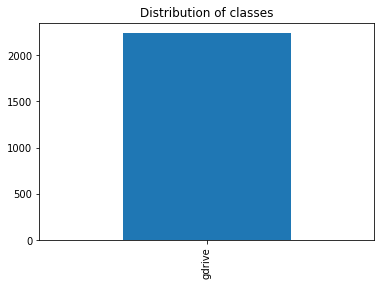

In [38]:
df=pd.DataFrame({"cancer_type":[str(x).split("/")[2] for x in train_path_list]})
df['cancer_type'].value_counts().plot(kind='bar')
plt.title("Distribution of classes")
plt.show()

Todo: Write your findings here:
- Which class has the least number of samples?
Ans : seborrheic keratosis
- Which classes dominate the data in terms proportionate number of samples?
Ans : pigmented benign keratosis

Todo: Rectify the class imbalance

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [40]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

- Instantiate a Pipeline object pointing to a directory containing your initial image data set.
- Define a number of operations to perform on this data set using your Pipeline object.
- Execute these operations by calling the Pipeline’s sample() method.

In [43]:
# Adding 500 samples per class to make sure that none of the classes are sparse.
path_to_training_dataset="/content/gdrive/MyDrive/CNN/kaggle/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 
    

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/kaggle/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9FBC072850>: 100%|██████████| 500/500 [00:22<00:00, 22.66 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/kaggle/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9FBCD8AD50>: 100%|██████████| 500/500 [00:21<00:00, 23.51 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/kaggle/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9FBC0588D0>: 100%|██████████| 500/500 [00:20<00:00, 24.65 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/kaggle/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9FBC072DD0>: 100%|██████████| 500/500 [01:28<00:00,  5.66 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/kaggle/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1019x717 at 0x7F9FBCC608D0>: 100%|██████████| 500/500 [01:36<00:00,  5.18 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/kaggle/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9FBD0B1890>: 100%|██████████| 500/500 [00:20<00:00, 24.77 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/kaggle/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9FD2072910>: 100%|██████████| 500/500 [00:46<00:00, 10.77 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/kaggle/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA04FE07790>: 100%|██████████| 500/500 [00:22<00:00, 22.26 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/kaggle/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9FBD323750>: 100%|██████████| 500/500 [00:19<00:00, 25.30 Samples/s]


- Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
image_count_train = len(list(data_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [45]:
from glob import glob


- Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
# path_list
path_list_new = [x for x in glob(os.path.join(data_train, '*','output', '*.jpg'))]


In [47]:
# lesion_list_new
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_train, '*','output', '*.jpg'))]

In [48]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [49]:
#created 500 samples for each
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

In [50]:
#new counts
new_list=list(df['cancer_type'].values)
new_list.extend(list(df2['Label'].values))
len(new_list)
final_df=pd.DataFrame({"cancer_type":new_list})
final_df['cancer_type'].value_counts()

gdrive                        2239
actinic keratosis              500
basal cell carcinoma           500
dermatofibroma                 500
melanoma                       500
nevus                          500
pigmented benign keratosis     500
seborrheic keratosis           500
squamous cell carcinoma        500
vascular lesion                500
Name: cancer_type, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Todo: Train the model on the data created using Augmentor

In [51]:
batch_size = 32
img_height = 180
img_width = 180

### Todo: Create a training dataset

In [52]:
data_train="/content/gdrive/MyDrive/CNN/kaggle/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Todo: Create a validation dataset

In [53]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Todo: Create your model (make sure to include normalization)

In [54]:
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.40),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.40),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

### Todo: Compile your model (Choose optimizer and loss function appropriately)

In [55]:
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 90, 90, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                 

### Todo: Train your model

In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 34s 190ms/step - loss: 2.7561 - accuracy: 0.1248 - val_loss: 2.1618 - val_accuracy: 0.1990
Epoch 2/50
169/169 [==============================] - 33s 187ms/step - loss: 1.9118 - accuracy: 0.2812 - val_loss: 1.8371 - val_accuracy: 0.3088
Epoch 3/50
169/169 [==============================] - 33s 188ms/step - loss: 1.6540 - accuracy: 0.3631 - val_loss: 1.9467 - val_accuracy: 0.2866
Epoch 4/50
169/169 [==============================] - 36s 208ms/step - loss: 1.5156 - accuracy: 0.4164 - val_loss: 1.6905 - val_accuracy: 0.3512
Epoch 5/50
169/169 [==============================] - 33s 188ms/step - loss: 1.4390 - accuracy: 0.4553 - val_loss: 1.4130 - val_accuracy: 0.4543
Epoch 6/50
169/169 [==============================] - 33s 187ms/step - loss: 1.3322 - accuracy: 0.4918 - val_loss: 1.5592 - val_accuracy: 0.4276
Epoch 7/50
169/169 [==============================] - 33s 187ms/step - loss: 1.2458 - accuracy: 0.5384 - val_loss: 1.3771 - val_ac

### Todo: Visualize the model results

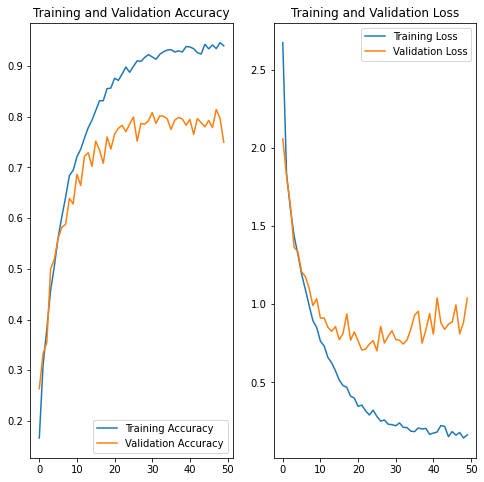

In [ ]:
# plot for Adam optimizer
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#trying with a different model optimizer 
model_imbalance_sgd = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_imbalance_sgd.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
## Your code goes here, use 50 epochs.
history_imbalance_sgd = model_imbalance_sgd.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 33s 185ms/step - loss: 2.1516 - accuracy: 0.1758 - val_loss: 2.1084 - val_accuracy: 0.1782
Epoch 2/30
169/169 [==============================] - 31s 178ms/step - loss: 2.0374 - accuracy: 0.2383 - val_loss: 1.9453 - val_accuracy: 0.2487
Epoch 3/30
169/169 [==============================] - 31s 181ms/step - loss: 1.9310 - accuracy: 0.2713 - val_loss: 1.8703 - val_accuracy: 0.3563
Epoch 4/30
169/169 [==============================] - 32s 182ms/step - loss: 1.8224 - accuracy: 0.3210 - val_loss: 1.8047 - val_accuracy: 0.3474
Epoch 5/30
169/169 [==============================] - 31s 181ms/step - loss: 1.7275 - accuracy: 0.3598 - val_loss: 1.7201 - val_accuracy: 0.4269
Epoch 6/30
169/169 [==============================] - 32s 184ms/step - loss: 1.6276 - accuracy: 0.3950 - val_loss: 1.5685 - val_accuracy: 0.4781
Epoch 7/30
169/169 [==============================] - 32s 182ms/step - loss: 1.5606 - accuracy: 0.4310 - val_loss: 1.5522 - val_ac

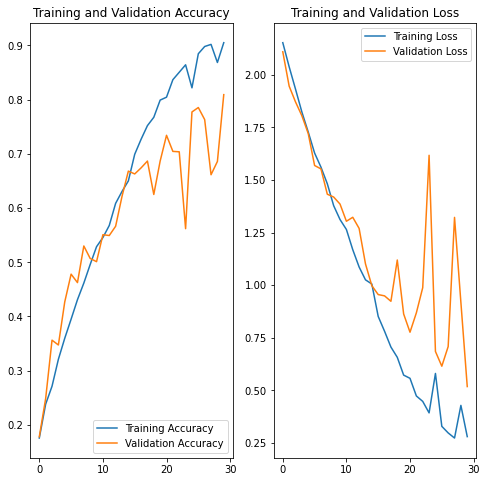

In [ ]:
# plot for SGD optimizer
acc = history_imbalance_sgd.history['accuracy']
val_acc = history_imbalance_sgd.history['val_accuracy']

loss = history_imbalance_sgd.history['loss']
val_loss = history_imbalance_sgd.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#trying with a different model 
model_imbalance_adagrad = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_imbalance_adagrad.compile(optimizer='adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
## Your code goes here, use 50 epochs.
history_imbalance_adagrad = model_imbalance_adagrad.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 34s 188ms/step - loss: 2.1636 - accuracy: 0.1673 - val_loss: 2.1484 - val_accuracy: 0.2227
Epoch 2/30
169/169 [==============================] - 33s 188ms/step - loss: 2.0900 - accuracy: 0.2059 - val_loss: 2.0688 - val_accuracy: 0.2747
Epoch 3/30
169/169 [==============================] - 33s 188ms/step - loss: 1.9798 - accuracy: 0.2602 - val_loss: 1.9551 - val_accuracy: 0.3237
Epoch 4/30
169/169 [==============================] - 32s 187ms/step - loss: 1.8666 - accuracy: 0.2980 - val_loss: 1.8394 - val_accuracy: 0.3645
Epoch 5/30
169/169 [==============================] - 32s 185ms/step - loss: 1.7773 - accuracy: 0.3284 - val_loss: 1.8461 - val_accuracy: 0.3482
Epoch 6/30
169/169 [==============================] - 33s 190ms/step - loss: 1.7149 - accuracy: 0.3539 - val_loss: 1.8052 - val_accuracy: 0.3237
Epoch 7/30
169/169 [==============================] - 33s 188ms/step - loss: 1.6641 - accuracy: 0.3795 - val_loss: 1.7476 - val_ac

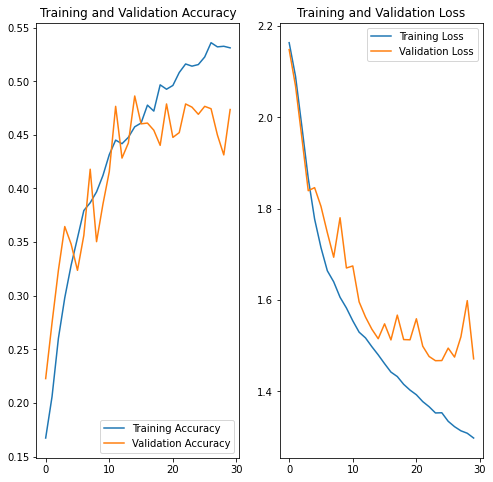

In [ ]:
#visualizing for adagrad
acc = history_imbalance_adagrad.history['accuracy']
val_acc = history_imbalance_adagrad.history['val_accuracy']

loss = history_imbalance_adagrad.history['loss']
val_loss = history_imbalance_adagrad.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- So we tried out the model with different epoch (30,50) and optimizers (adam, sgd , adaagrad). The initial model with adam optimizer with 50 epochs seems to work well with validation accuracy reaching about 80% .

In [ ]:
#checking the performance on the test set 
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  # print(model.predict_classes(images))
  # print(labels.numpy())
  y_true=list(labels.numpy())
  y_pred=np.argmax(model.predict(images), axis=-1)
  # break
  print("Adam optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred=np.argmax(model_imbalance_adagrad.predict(images), axis=-1)
  # break
  print("Adagrad optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred=np.argmax(model_imbalance_sgd.predict(images), axis=-1)
  # break
  print("SGD optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)

Adam optimizer
                            precision    recall  f1-score   support

         actinic keratosis       0.50      0.31      0.38        16
      basal cell carcinoma       0.31      0.25      0.28        16
            dermatofibroma       0.67      0.12      0.21        16
                  melanoma       0.22      0.31      0.26        16
                     nevus       0.25      0.44      0.32        16
pigmented benign keratosis       0.37      0.44      0.40        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.24      0.25      0.24        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.31       118
                 macro avg       0.36      0.31      0.31       118
              weighted avg       0.36      0.31      0.30       118

Accuracy on test dataset :  0.3050847457627119
********************
Adagrad optimizer
            

## Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

### We tried different models with optimizers (sgd, adam, adagrad) and epochs (30,50,30). By adding augmented images which inturn helped in handling class imbalance , we mitigated/addressed the problem of overfitting . Out of all the models the performance was decent for the model with Adam's optimizer. The model had a train accuracy of ~90% while the validation accuracy was about ~80% . This model learns rapidly (increase in training and validation accuracy)for the first 20 epochs , but after this the learning becomes slow.